**TODO**: 
- [x] improve progress bar
- [x] remove early races?
- [x] migliora splitting di tr/vl (correggere validation che include test)
- [x] introduce `race_country == nationality`
- [x] recompute `is_tarmac`
- [] can we reorder seasons from colder to warmer? does it make sense?
- [] try different sampling strategy
- [x] use GPU (hopefully speeds up grid search)
- [] retrain model using all the development set
- [] decide the important metrics (probaly f1 and precision/recall of winners)
- [] study hyperparameter of XGB
- [] grid search for FBT (it is not giving good results)
- [] compare with normal tree
- [] compute metrics of FBT
- [] refactor this notebook
- [] how does the prediction changes changing one input (explainability)

# CREATING THE DATASET

In [1]:
# As always we start by importing the necessary libraries
# and loading the data we will be working with. (at this point I'm importing stuff just for the fun of it)
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utility.classification_utility import *

# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = True

cyc = '../dataset/cyclists_cleaned.csv'
races = '../dataset/races_cleaned.csv'

full_df = get_merged_dataset(cyc, races)
full_df = define_target(full_df) 

In [2]:
#full_df = define_target(full_df)
full_df[['points', 'position', 'average_speed', 'stamina_index']]
print('points:', full_df['points'].isna().sum())
print('position:',full_df['position'].isna().sum())
print('average_speed:',full_df['average_speed'].isna().sum())
print('stamina_index:',full_df['stamina_index'].isna().sum())

points: 0
position: 0
average_speed: 0
stamina_index: 137267


In [3]:
full_df.columns

Index(['_url_rac', 'name_rac', 'stage', 'stage_type', 'points', 'length',
       'climb_total', 'profile', 'startlist_quality', 'date', 'position',
       'cyclist', 'cyclist_age_rac', 'is_tarmac', 'delta', 'time',
       'time_seconds', 'average_speed', 'steepness', 'season', 'is_staged',
       'race_country', 'age_performance_index', 'quality_adjusted_points',
       'stamina_index', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points', 'avg_points_per_race',
       'average_position', 'avg_speed_cyclist', 'cyclist_age_cyc',
       'mean_stamina_index', 'target'],
      dtype='object')

In [4]:
full_df = recompute_metrics(full_df,
                  avg_points_per_race_D=-1,
                  average_position_D=-1,
                  avg_speed_cyclist_D=-1,
                  mean_stamina_index_D=-1,
                  total_points_D=-1,
                  elapsed_from_last_race_D=-1,
                  missing_value_policy='mean')

100.00%  


In [5]:
full_df = define_target(full_df)

## Let's see if everything seems reasonable

In [6]:
stef = full_df[full_df['cyclist'] == 'tadej-pogacar']
math_ = full_df[full_df['cyclist'] == 'mathieu-van-der-poel']
math_ = math_.sort_values(by='date')
stef_sorted = stef.sort_values(by='date')
stef_sorted[['_url_rac', 'cyclist', 'points', 'total_points', 'date', 'elapsed_from_last', 'position', 'avg_points_per_race']][20:30]

,_url_rac,cyclist,points,total_points,date,elapsed_from_last,position,avg_points_per_race
464678,vuelta-a-espana/2019/stage-16,tadej-pogacar,2.0,264.0,2019-09-09,1.0,13,13.200000
464847,vuelta-a-espana/2019/stage-17,tadej-pogacar,0.0,266.0,2019-09-11,2.0,30,12.666667
464940,vuelta-a-espana/2019/stage-18,tadej-pogacar,8.0,266.0,2019-09-12,1.0,8,12.090909
465103,vuelta-a-espana/2019/stage-19,tadej-pogacar,10.0,274.0,2019-09-13,1.0,7,11.913043
465368,vuelta-a-espana/2019/stage-20,tadej-pogacar,80.0,284.0,2019-09-14,1.0,0,11.833333
465487,vuelta-a-espana/2019/stage-21,tadej-pogacar,0.0,364.0,2019-09-15,1.0,24,14.560000
465746,world-championship/2019/result,tadej-pogacar,34.0,364.0,2019-09-29,14.0,17,14.000000
465953,uae-tour/2020/stage-1,tadej-pogacar,0.0,398.0,2020-02-23,147.0,24,14.740741
466023,uae-tour/2020/stage-2,tadej-pogacar,2.0,398.0,2020-02-24,1.0,8,14.214286
466268,uae-tour/2020/stage-3,tadej-pogacar,30.0,400.0,2020-02-25,1.0,1,13.793103


In [7]:
list(set(list(stef_sorted['date']) + list(math_['date']))).sort()

100%|██████████| 193/193 [00:00<00:00, 2979.22it/s]


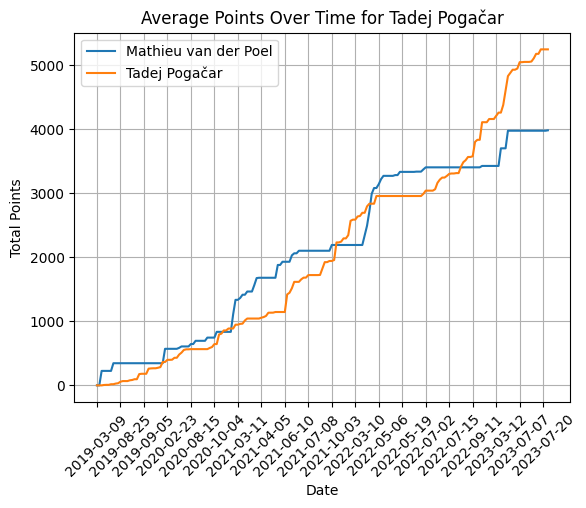

In [8]:
from tqdm import tqdm


total_points_tad = [0]
total_points_math = [0]
dates = list(stef_sorted['date']) + list(math_['date'])
dates = list(set(dates))
dates.sort()
for date in tqdm(dates):
    if date not in list(stef_sorted['date']):
        total_points_tad.append(total_points_tad[-1])
    else:
        total_points_tad.append(stef_sorted[stef_sorted['date'] == date]['total_points'].values[0])

    if date not in list(math_['date']):
        total_points_math.append(total_points_math[-1])
    else:
        total_points_math.append(math_[math_['date'] == date]['total_points'].values[0])

total_points_math.remove(0)
total_points_tad.remove(0)
plt.plot(dates, total_points_math, label='Mathieu van der Poel')
plt.plot(dates, total_points_tad, label='Tadej Pogačar')
plt.xlabel('Date')
plt.ylabel('Total Points')
plt.title('Average Points Over Time for Tadej Pogačar')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.xticks(dates[::10])
plt.show()

In [9]:
setzu = full_df[full_df['cyclist'] == 'mattia-setzu']
print(setzu)

Empty DataFrame
Columns: [_url_rac, name_rac, stage, stage_type, points, length, climb_total, profile, startlist_quality, date, position, cyclist, cyclist_age_rac, is_tarmac, delta, time, time_seconds, average_speed, steepness, season, is_staged, race_country, age_performance_index, quality_adjusted_points, stamina_index, birth_year, weight, height, nationality, bmi, race_count, experience_level, total_points, avg_points_per_race, average_position, avg_speed_cyclist, cyclist_age_cyc, mean_stamina_index, target, elapsed_from_last]
Index: []

[0 rows x 40 columns]


this gives an error, looks like some of the stronger cyclist of our age are not in the dataset...

In [10]:
full_df[['position', 'target']]

,position,target
0,29,False
1,15,True
2,16,True
3,17,True
4,18,True
...,...,...
523068,15,True
523069,16,True
523070,17,True
523071,8,True


## Prepare dataset for XGB (other models may have different preparaton)

In [11]:
'race_country' == 'nationality'
'experience_level' # to encode
'is_tarmac' # recompute as int (0, 1) for explainability
'season', # explainability can't handle categorical data

dataset = full_df.copy()

dataset['is_tarmac'] = dataset['is_tarmac'].astype(int)
dataset['experience_level'] = dataset['experience_level'].apply(lambda x: EXPERIENCE_LEVELS.index(x))
dataset['home_game'] = dataset.apply(lambda x: 1 if x['race_country'] == x['nationality'] else 0, axis=1)

TO_USE_COLS = [
    # over time
    'total_points', 'avg_points_per_race', 
    'average_position', 'avg_speed_cyclist', 'mean_stamina_index',
    'race_count',
    # race related
    'length', 'climb_total', 'profile', 
    'startlist_quality', 'cyclist_age_rac', 'steepness', 
    'is_tarmac',
    # cyclist related
    'weight', 'height', 'bmi',
    'experience_level', 'home_game',
]

# TRAINING VALIDATION TEST SPLIT
tr_data = dataset[(dataset['date'] < '2019-01-01') & (dataset['date'] >= '1996-01-01')]
print(tr_data['date'].min(), tr_data['date'].max())
tr_out = tr_data['target']
tr_data = tr_data[TO_USE_COLS]

val_data = dataset[(dataset['date'] >= '2019-01-01') & (dataset['date'] < '2022-01-01')]
print(val_data['date'].min(), val_data['date'].max())
val_out = val_data['target']
val_data = val_data[TO_USE_COLS]

ts_data = dataset[dataset['date'] >= '2022-01-01']
print(ts_data['date'].min(), ts_data['date'].max())
ts_out = ts_data['target']
ts_data = ts_data[TO_USE_COLS]

tot = full_df[full_df['date'] >= '1996-01-01'].shape[0]
print('Training data:', tr_data.shape, 'i.e.', f'{(tr_data.shape[0] / tot)*100:.2f}', '%')
print('Validation data:', val_data.shape, 'i.e.', f'{(val_data.shape[0] / tot)*100:.2f}', '%')
print('Test data:', ts_data.shape, 'i.e.', f'{(ts_data.shape[0] / tot)*100:.2f}', '%')

print(f'Percentage of positive samples in training data: {tr_out.mean()}')
print(f'Percentage of positive samples in validation data: {val_out.mean()}')

1996-03-02 2018-10-13
2019-02-26 2021-10-09
2022-02-21 2023-07-29
Training data: (355140, 18) i.e. 82.77 %
Validation data: (43480, 18) i.e. 10.13 %
Test data: (30429, 18) i.e. 7.09 %
Percentage of positive samples in training data: 0.14546939235231177
Percentage of positive samples in validation data: 0.14344526218951242


# XGB grid search

## GPU

In [12]:
if False:
    import json # for saving hyperparameters and results
    from random import shuffle
    from time import sleep
    import xgboost as xgb # for the model
    from itertools import product #for grid search
    from tqdm import tqdm # for progress bar
    from sklearn.metrics import classification_report, f1_score # for evaluation
    from imblearn.over_sampling import RandomOverSampler # for oversampling
    def f1_macro(x, y):     # for our evaluation
        return f1_score(x, y, average='macro')

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
    tr_data, tr_out = oversample.fit_resample(tr_data, tr_out)
    tr_data = tr_data.reset_index(drop=True)
    tr_out = tr_out.reset_index(drop=True)

    dtrain = xgb.DMatrix(tr_data, label=tr_out, enable_categorical=True)
    dval = xgb.DMatrix(val_data, label=val_out, enable_categorical=True)
    dval_no_label = xgb.DMatrix(val_data, enable_categorical=True)

    N_estimators = [200, 300, 400, 600, 800]
    Learning_rate = [0.05, 0.1, 0.15, 0.2]
    Lambda_reg = [0.1, 0.5, 1, 2, 5]
    Early_stopping_rounds = [10, 30, 50]
    Max_depth = [3, 5, 9]
    hyperparameters = list(product(N_estimators, Learning_rate, Lambda_reg, Early_stopping_rounds, Max_depth))
    shuffle(hyperparameters)

    best_score = 0
    best_params = None
    hyperparameterStore = []
    runs = 0

    with open('./XGB_hyperparameters.json', 'r') as f:
        hyperparameterStore = json.load(f)

    for n_estimators, learning_rate, lambda_reg, early_stop, max_depth in tqdm(hyperparameters, total=len(hyperparameters), colour='green', smoothing=0):
        params = {
            'eta': learning_rate, 
            'reg_lambda': lambda_reg,
            'max_depth': max_depth,
            'objective': 'binary:logistic',
            'device': 'cuda',
            'tree_method': 'hist',
            'seed': RANDOM_STATE,
            'verbosity': 0,
            }
        model = xgb.train(
            params, 
            dtrain, 
            num_boost_round=n_estimators,
            evals=[(dtrain, 'train'), (dval, 'val')],
            early_stopping_rounds=early_stop,
            verbose_eval=False
        )
        val_pred = model.predict(dval_no_label)
        val_pred = (val_pred > 0.5).astype(int)
        score = f1_macro(val_out, val_pred)
        param_run = {'n_estimators': n_estimators, 
                    'learning_rate': learning_rate, 
                    'lambda_reg': lambda_reg,
                    'early_stop': early_stop, 
                    'max_depth': max_depth,
                    'score': classification_report(val_out, val_pred, output_dict=True),
                    }
        hyperparameterStore.append(param_run)
        if score > best_score:
            best_score = score
            best_params = param_run
            # save results up to now
            with open('./XGB_hyperparameters.json', 'w') as f:
                f.write(json.dumps(hyperparameterStore, indent=4))
        runs += 1
        if runs == 20:
            runs = 0
            sleep(2) # to avoid destroying my computer

    print(f'Best score: {best_score:.4f}')
    print(f'Best parameters: {best_params}')

sooo, 1h and 35min... we will run smaller searches after this one, but this is an important overview of where we need to go in order to improve the results that are quite unsatifactory.

In [28]:
import json

with open('./XGB_hyperparameters.json', 'r') as f:
    hyperparameterStore = json.load(f)

hyperparameterStore.sort(key=lambda x: x['score']['macro avg']['f1-score'], reverse=True)

for i, params in enumerate(hyperparameterStore[0:20]):
    print(f'{(i+1):2d}. F1-score: {params["score"]["macro avg"]["f1-score"]:.3f} - \
{params["n_estimators"]:4d} estimators, \
{params["learning_rate"]:1f} learning rate, \
{params["lambda_reg"]:.1f} lambda, \
{params["early_stop"]} early stop, \
{params["max_depth"]} max depth')

 1. F1-score: 0.675 -  800 estimators, 0.100000 learning rate, 5.0 lambda, 50 early stop, 9 max depth
 2. F1-score: 0.671 -  600 estimators, 0.100000 learning rate, 5.0 lambda, 50 early stop, 9 max depth
 3. F1-score: 0.671 -  600 estimators, 0.100000 learning rate, 5.0 lambda, 10 early stop, 9 max depth
 4. F1-score: 0.668 -  800 estimators, 0.100000 learning rate, 1.0 lambda, 30 early stop, 9 max depth
 5. F1-score: 0.668 -  800 estimators, 0.050000 learning rate, 5.0 lambda, 10 early stop, 9 max depth
 6. F1-score: 0.668 -  800 estimators, 0.050000 learning rate, 5.0 lambda, 30 early stop, 9 max depth
 7. F1-score: 0.668 -  800 estimators, 0.050000 learning rate, 5.0 lambda, 50 early stop, 9 max depth
 8. F1-score: 0.668 -  800 estimators, 0.050000 learning rate, 1.0 lambda, 10 early stop, 9 max depth
 9. F1-score: 0.668 -  800 estimators, 0.050000 learning rate, 1.0 lambda, 50 early stop, 9 max depth
10. F1-score: 0.668 -  800 estimators, 0.050000 learning rate, 1.0 lambda, 30 earl

The only hyperparameter taht does not change in the top 20 results is the max depth, so we'll do some hyperparameter tuning focusing more on the max depth

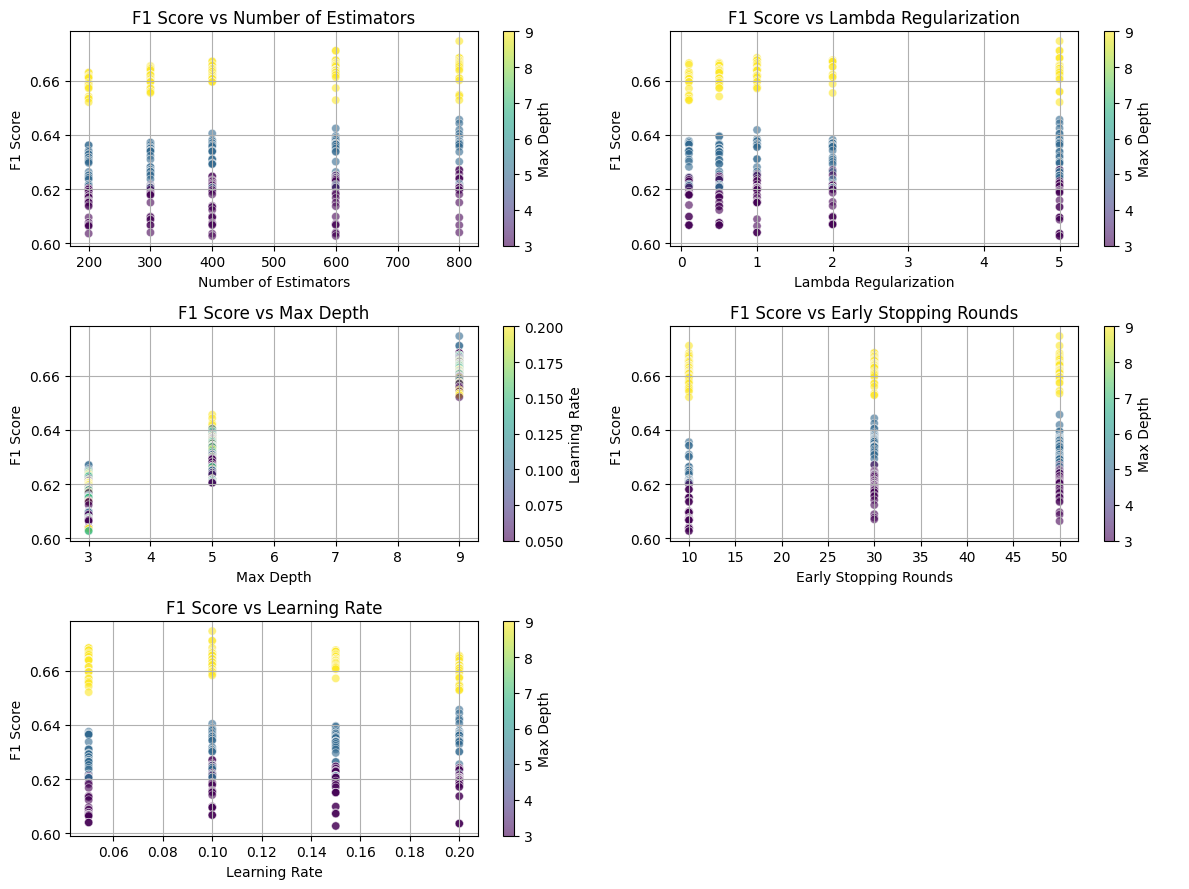

In [14]:
import matplotlib.pyplot as plt

# Extract the hyperparameters and their corresponding F1 scores
n_estimators = [param['n_estimators'] for param in hyperparameterStore]
lambda_regs = [param['lambda_reg'] for param in hyperparameterStore]
max_depths = [param['max_depth'] for param in hyperparameterStore]
early_stops = [param['early_stop'] for param in hyperparameterStore]
learning_rates = [param['learning_rate'] for param in hyperparameterStore]
f1_scores = [param['score']['macro avg']['f1-score'] for param in hyperparameterStore]

fig, axs = plt.subplots(3, 2, figsize=(12, 9))

# Scatter plot for number of estimators
scatter = axs[0, 0].scatter(n_estimators, f1_scores, c=max_depths, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
axs[0, 0].set_xlabel('Number of Estimators')
axs[0, 0].set_ylabel('F1 Score')
axs[0, 0].set_title('F1 Score vs Number of Estimators')
axs[0, 0].grid(True)
fig.colorbar(scatter, ax=axs[0, 0], label='Max Depth')

# Scatter plot for lambda_reg
scatter = axs[0, 1].scatter(lambda_regs, f1_scores, c=max_depths, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
axs[0, 1].set_xlabel('Lambda Regularization')
axs[0, 1].set_ylabel('F1 Score')
axs[0, 1].set_title('F1 Score vs Lambda Regularization')
axs[0, 1].grid(True)
fig.colorbar(scatter, ax=axs[0, 1], label='Max Depth')

# Scatter plot for max_depth
scatter = axs[1, 0].scatter(max_depths, f1_scores, c=learning_rates, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
axs[1, 0].set_xlabel('Max Depth')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].set_title('F1 Score vs Max Depth')
axs[1, 0].grid(True)
fig.colorbar(scatter, ax=axs[1, 0], label='Learning Rate')

# Scatter plot for early_stops
scatter = axs[1, 1].scatter(early_stops, f1_scores, c=max_depths, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
axs[1, 1].set_xlabel('Early Stopping Rounds')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].set_title('F1 Score vs Early Stopping Rounds')
axs[1, 1].grid(True)
fig.colorbar(scatter, ax=axs[1, 1], label='Max Depth')

# Scatter plot for learning_rates
scatter = axs[2, 0].scatter(learning_rates, f1_scores, c=max_depths, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
axs[2, 0].set_xlabel('Learning Rate')
axs[2, 0].set_ylabel('F1 Score')
axs[2, 0].set_title('F1 Score vs Learning Rate')
axs[2, 0].grid(True)
fig.colorbar(scatter, ax=axs[2, 0], label='Max Depth')

# Hide the empty subplot
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


Well... all hyperparameters are equal, but some hyperparameters are more equals than other

Since we can clearly see that the more we allow to the tree to grow deep the more we gain let's fine the limit

**NOTE**: I forgot to add oversampling at the first iteration and results were 3-4 points lower (If anybody was wondering why that oversampling strategy)

In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report
from itertools import product
import json
import random
from imblearn.over_sampling import RandomOverSampler # for oversampling
from time import sleep
from tqdm import tqdm
def f1_macro(x, y):
    return f1_score(x, y, average='macro')
if False:
    TEST = 20

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
    tr_data, tr_out = oversample.fit_resample(tr_data, tr_out)
    tr_data = tr_data.reset_index(drop=True)
    tr_out = tr_out.reset_index(drop=True)

    # Define the parameter grid
    param_dist = {
        'n_estimators': [300, 400, 500, 600, 700, 800],# 400 seem to be more stable but 800 yeilds better results
        'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
        'max_depth': [9, 11 ,12, 13, 14], # go over 15 is too slow and it requires a lot of memory
        'reg_lambda': [1, 2, 3, 4, 5],
        'early_stopping_rounds': [30, 40, 50]
    }

    to_try = list(
        product(
            param_dist['n_estimators'], 
            param_dist['learning_rate'],
            param_dist['reg_lambda'], 
            param_dist['early_stopping_rounds']
        )
    )

    dtrain = xgb.DMatrix(tr_data, label=tr_out, enable_categorical=True)
    dval = xgb.DMatrix(val_data, label=val_out, enable_categorical=True)
    dval_no_label = xgb.DMatrix(val_data, enable_categorical=True)

    # Take a random sample of TEST elements from to_try
    to_try = random.sample(to_try, TEST if len(to_try) > TEST else len(to_try))
    # Initialize variables to store the best parameters and score
    best_score = 0
    best_params = None
    hyperparameterStore = []

    runs = 0
    # Iterate over all combinations of hyperparameters
    for max_depth in param_dist['max_depth']:
        print(f'Max depth: {max_depth}')
        for _ in tqdm(range(TEST), total=TEST, colour='green', smoothing=0):
            n_estimators = random.choice(param_dist['n_estimators'])
            learning_rate = random.choice(param_dist['learning_rate'])
            reg_lambda = random.choice(param_dist['reg_lambda'])
            early_stopping_rounds = random.choice(param_dist['early_stopping_rounds'])
            params = {
                'eta': learning_rate, 
                'reg_lambda': reg_lambda,
                'max_depth': max_depth,
                'objective': 'binary:logistic',
                'device': 'cuda',
                'tree_method': 'hist',
                'seed': RANDOM_STATE,
                'verbosity': 0,
            }
            model = xgb.train(
                params = params, 
                dtrain = dtrain, 
                num_boost_round=n_estimators,
                evals=[(dtrain, 'train'), (dval, 'val')],
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=False
            )
            val_pred = model.predict(dval_no_label)
            val_pred = (val_pred > 0.5).astype(int)
            score = f1_macro(val_out, val_pred)
            param_run = {'n_estimators': n_estimators, 
                        'learning_rate': learning_rate, 
                        'lambda_reg': reg_lambda,
                        'early_stop': early_stopping_rounds, 
                        'max_depth': max_depth,
                        'score': classification_report(val_out, val_pred, output_dict=True),
                        }
            hyperparameterStore.append(param_run)
            if score > best_score:
                best_score = score
                best_params = param_run
                # save results up to now
                with open('./XGB_rs_hyperparameters.json', 'w') as f:
                    f.write(json.dumps(hyperparameterStore, indent=4))
            runs += 1
            if runs == 20:
                runs = 0
                sleep(2) # to avoid destroying my computer

    with open('./XGB_rs_hyperparameters.json', 'w') as f:
        f.write(json.dumps(hyperparameterStore, indent=4))

    print(f'Best score: {best_score:.4f}')
    print(f'Best parameters: {best_params}')

Max depth: 9


100%|██████████| 20/20 [05:19<00:00, 15.97s/it]


Max depth: 11


100%|██████████| 20/20 [06:14<00:00, 18.75s/it]


Max depth: 12


100%|██████████| 20/20 [06:23<00:00, 19.16s/it]


Max depth: 13


100%|██████████| 20/20 [08:00<00:00, 24.02s/it]


Max depth: 14


100%|██████████| 20/20 [08:11<00:00, 24.59s/it]

Best score: 0.6770
Best parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'lambda_reg': 5, 'early_stop': 50, 'max_depth': 12, 'score': {'False': {'precision': 0.9147455780031856, 'recall': 0.8789839701420401, 'f1-score': 0.8965082842667397, 'support': 37243.0}, 'True': {'precision': 0.4141427271545561, 'recall': 0.5108225108225108, 'f1-score': 0.4574300071787509, 'support': 6237.0}, 'accuracy': 0.8261729530818768, 'macro avg': {'precision': 0.6644441525788708, 'recall': 0.6949032404822755, 'f1-score': 0.6769691457227452, 'support': 43480.0}, 'weighted avg': {'precision': 0.8429364708103866, 'recall': 0.8261729530818768, 'f1-score': 0.8335245856881338, 'support': 43480.0}}}


In [29]:
with open('./XGB_rs_hyperparameters.json', 'r') as f:
    hyperparameterStore = json.load(f)

hyperparameterStore.sort(key=lambda x: x['score']['macro avg']['f1-score'], reverse=True)
for i, params in enumerate(hyperparameterStore[0:20]):
    print(f'{(i+1):2d}. F1-score: {params["score"]["macro avg"]["f1-score"]:.3f} - \
{params["n_estimators"]:4d} estimators, \
{params["learning_rate"]:1f} learning rate, \
{params["lambda_reg"]:.1f} lambda, \
{params["early_stop"]} early stop, \
{params["max_depth"]} max depth')

 1. F1-score: 0.677 -  500 estimators, 0.050000 learning rate, 5.0 lambda, 50 early stop, 12 max depth
 2. F1-score: 0.676 -  300 estimators, 0.050000 learning rate, 3.0 lambda, 30 early stop, 14 max depth
 3. F1-score: 0.676 -  300 estimators, 0.050000 learning rate, 3.0 lambda, 50 early stop, 14 max depth
 4. F1-score: 0.676 -  500 estimators, 0.050000 learning rate, 4.0 lambda, 40 early stop, 12 max depth
 5. F1-score: 0.676 -  500 estimators, 0.100000 learning rate, 5.0 lambda, 50 early stop, 11 max depth
 6. F1-score: 0.675 -  300 estimators, 0.100000 learning rate, 5.0 lambda, 30 early stop, 11 max depth
 7. F1-score: 0.675 -  500 estimators, 0.050000 learning rate, 4.0 lambda, 50 early stop, 11 max depth
 8. F1-score: 0.675 -  600 estimators, 0.050000 learning rate, 5.0 lambda, 30 early stop, 11 max depth
 9. F1-score: 0.674 -  700 estimators, 0.100000 learning rate, 5.0 lambda, 30 early stop, 11 max depth
10. F1-score: 0.674 -  600 estimators, 0.050000 learning rate, 3.0 lambda

At this point I'd say we can stop here the hyperparameter tuning because after incrasing the depth we gained almost nothing more than a warm computer

/tmp/ipykernel_2614/1622137792.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(grouped_f1_scores, labels=sorted(set(max_depths)))


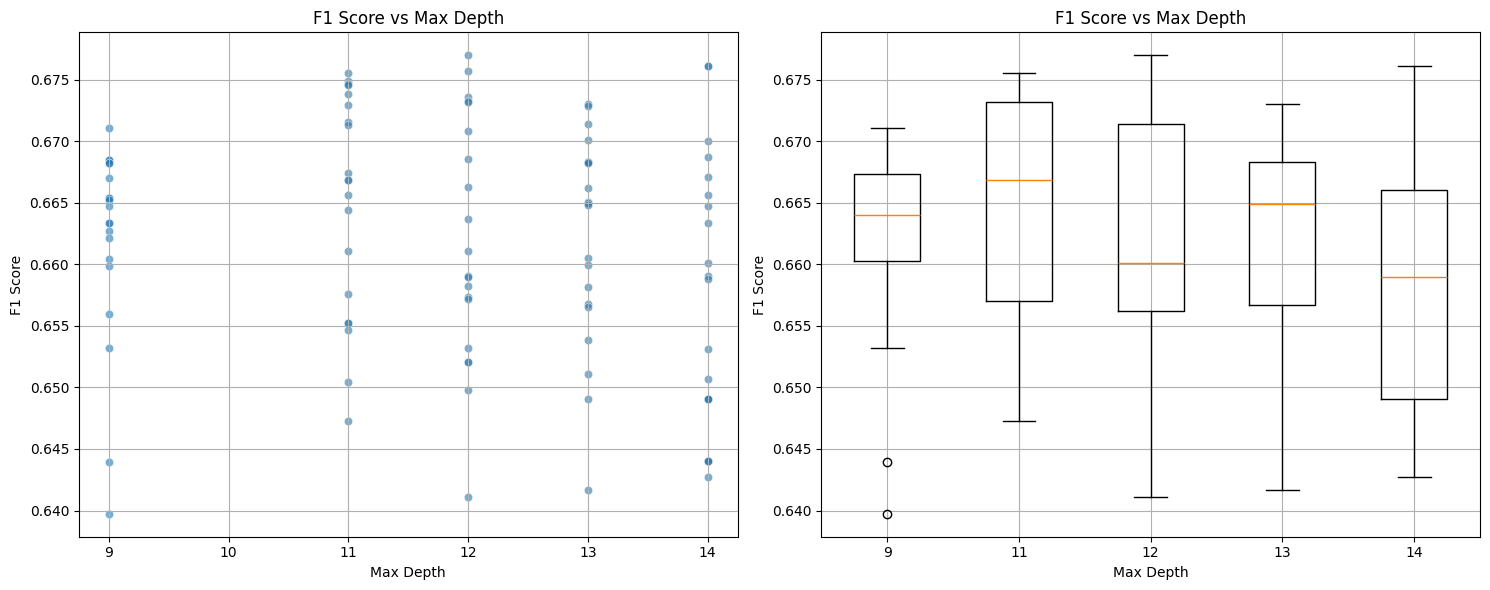

In [37]:
import matplotlib.pyplot as plt

# Extract the max_depths and their corresponding F1 scores
max_depths = [param['max_depth'] for param in hyperparameterStore]
f1_scores = [param['score']['macro avg']['f1-score'] for param in hyperparameterStore]

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
axs[0].scatter(max_depths, f1_scores, alpha=0.6, edgecolors='w', linewidth=0.5)
axs[0].set_xlabel('Max Depth')
axs[0].set_ylabel('F1 Score')
axs[0].set_title('F1 Score vs Max Depth')
axs[0].grid(True)

# Box plot for max_depths vs F1 scores
grouped_f1_scores = [[f1_scores[j] for j in range(len(max_depths)) if max_depths[j] == depth] for depth in sorted(set(max_depths))]
axs[1].boxplot(grouped_f1_scores, labels=sorted(set(max_depths)))
axs[1].set_xlabel('Max Depth')
axs[1].set_ylabel('F1 Score')
axs[1].set_title('F1 Score vs Max Depth')
axs[1].grid(True)

plt.tight_layout()
plt.show()

Unfortunately we see that increase the depth of the tree is not enough to improve significantly the f1-score

In [52]:
best_params = hyperparameterStore[0]
print(f'Estimators: {best_params["n_estimators"]}, Learning rate: {best_params["learning_rate"]}\nLambda: {best_params["lambda_reg"]}, Early stop: {best_params["early_stop"]}, Max depth: {best_params["max_depth"]}')
print(json.dumps(best_params['score'], indent=4))

Estimators: 500, Learning rate: 0.05
Lambda: 5, Early stop: 50, Max depth: 12
{
    "False": {
        "precision": 0.9147455780031856,
        "recall": 0.8789839701420401,
        "f1-score": 0.8965082842667397,
        "support": 37243.0
    },
    "True": {
        "precision": 0.4141427271545561,
        "recall": 0.5108225108225108,
        "f1-score": 0.4574300071787509,
        "support": 6237.0
    },
    "accuracy": 0.8261729530818768,
    "macro avg": {
        "precision": 0.6644441525788708,
        "recall": 0.6949032404822755,
        "f1-score": 0.6769691457227452,
        "support": 43480.0
    },
    "weighted avg": {
        "precision": 0.8429364708103866,
        "recall": 0.8261729530818768,
        "f1-score": 0.8335245856881338,
        "support": 43480.0
    }
}


## CPU

In [13]:
if False:
    from random import shuffle
    from xgboost import XGBClassifier # XGBoost classifier
    import xgboost as xgb
    from itertools import product #for grid search
    from tqdm import tqdm # for progress bar
    from sklearn.metrics import classification_report, f1_score # for evaluation

    from imblearn.over_sampling import RandomOverSampler # for oversampling
    f1_macro = lambda x, y: f1_score(x, y, average='macro') # for our evaluation

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
    tr_data, tr_out = oversample.fit_resample(tr_data, tr_out)
    tr_data = tr_data.reset_index(drop=True)
    tr_out = tr_out.reset_index(drop=True)

    # Hyperparameters
    N_estimators = [30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]
    N_estimators = [200]
    Learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
    Learning_rate = [0.1]
    # Shuffle hyperparameters to have a more accurate progress bar
    hyperparameters = list(product(N_estimators, Learning_rate))
    shuffle(hyperparameters)

    # Grid search
    best_score = 0
    best_params = None
    for n_estimators, learning_rate in tqdm(hyperparameters, total=len(hyperparameters), colour='green', smoothing=0.4):
        xgb_model = XGBClassifier(
            n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            n_jobs=-1, 
            random_state=42,
            objective='binary:logistic',
        )
        xgb_model.fit(tr_data, tr_out)
        val_pred = xgb_model.predict(val_data)
        score = f1_macro(val_out, val_pred)
        if score > best_score:
            best_score = score
            best_params = (n_estimators, learning_rate)

    # Train the model with the best hyperparameters
    n_estimators, learning_rate = best_params
    xgb_model = XGBClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        n_jobs=-1, 
        random_state=42,
        objective='binary:logistic',
    )
    xgb_model.fit(tr_data, tr_out)

    # Predict
    val_pred = xgb_model.predict(val_data)
    print(f'val f1-score: {f1_macro(val_out, val_pred)}')
    print(classification_report(val_out, val_pred))
    print(f'Best hyperparameters: {best_params}')
    print(f'Best score: {best_score}')

100%|██████████| 1/1 [00:13<00:00, 13.15s/it]
/home/d.borghini/miniconda3/envs/dm/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:39:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/home/d.borghini/miniconda3/envs/dm/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:39:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


val f1-score: 0.6348663061063695
              precision    recall  f1-score   support

       False       0.94      0.74      0.83     37243
        True       0.32      0.73      0.44      6237

    accuracy                           0.74     43480
   macro avg       0.63      0.73      0.63     43480
weighted avg       0.85      0.74      0.77     43480

Best hyperparameters: (200, 0.1)
Best score: 0.6348663061063695


# Tests

As first thing we will create the forest to explain obtained with the grid search

the following code can be executed skipping all the cells above to simplify the workflow

In [8]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import xgboost as xgb
import json
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from utility.classification_utility import *

# we define a random state to make the results reproducible
RANDOM_STATE = 42

cyc_path = '../dataset/cyclists_cleaned.csv'
races_path = '../dataset/races_cleaned.csv'
print('Loading data...')
dataset = make_dataset_for_classification(races_df=races_path, cyclists_df=cyc_path)

TO_USE_COLS = [
    # over time
    'total_points', 'avg_points_per_race', 
    'average_position', 'avg_speed_cyclist', 'mean_stamina_index',
    'race_count',
    # race related
    'length', 'climb_total', 'profile', 
    'startlist_quality', 'cyclist_age_rac', 'steepness', 
    'is_tarmac',
    # cyclist related
    'weight', 'height', 'bmi',
    'experience_level', 'home_game',
]

dataset['is_tarmac'] = dataset['is_tarmac'].astype(int)
dataset['experience_level'] = dataset['experience_level'].apply(lambda x: EXPERIENCE_LEVELS.index(x))

# TRAINING VALIDATION TEST SPLIT
tr_data = dataset[(dataset['date'] < '2019-01-01') & (dataset['date'] >= '1996-01-01')]
tr_out = tr_data['target']
tr_data = tr_data[TO_USE_COLS]
val_data = dataset[(dataset['date'] >= '2019-01-01') & (dataset['date'] < '2022-01-01')]
val_out = val_data['target']
val_data = val_data[TO_USE_COLS]
ts_data = dataset[dataset['date'] >= '2022-01-01']
ts_out = ts_data['target']
ts_data = ts_data[TO_USE_COLS]

oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
tr_data, tr_out = oversample.fit_resample(tr_data, tr_out)
dtrain = xgb.DMatrix(tr_data, label=tr_out, enable_categorical=True)
dval = xgb.DMatrix(val_data, label=val_out, enable_categorical=True)
dval_no_label = xgb.DMatrix(val_data, enable_categorical=True)

print('Data loaded, searching for best hyperparameters...')
with open('./XGB_rs_hyperparameters.json', 'r') as f:
    hyperparameterStore = json.load(f)

hyperparameterStore.sort(key=lambda x: x['score']['macro avg']['f1-score'], reverse=True)
best_params = hyperparameterStore[0]

params = {
    'eta': best_params['learning_rate'], 
    'reg_lambda': best_params['lambda_reg'],
    'max_depth': best_params['max_depth'],
    'objective': 'binary:logistic',
    'device': 'cuda',
    'tree_method': 'hist',
    'seed': RANDOM_STATE,
    'verbosity': 0,
}
print('Training model...')
model = xgb.train(
    params = params, 
    dtrain = dtrain, 
    num_boost_round=best_params['n_estimators'],
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=best_params['early_stop'],
    verbose_eval=False
)
print('Model trained, evaluating...')
val_pred = model.predict(dval_no_label)
val_pred = (val_pred > 0.5).astype(int)
print(classification_report(val_out, val_pred))

Loading data...
100.00%  
Data loaded, searching for best hyperparameters...
Training model...
Model trained, evaluating...
              precision    recall  f1-score   support

       False       0.91      0.88      0.90     37243
        True       0.41      0.51      0.46      6237

    accuracy                           0.83     43480
   macro avg       0.66      0.69      0.68     43480
weighted avg       0.84      0.83      0.83     43480



what does happens if we keep the top 20 (the ones with higher probability of being in the top 20 in each race)

do we imporve the scores of the model?

In [56]:
exp_val = dataset[(dataset['date'] >= '2019-01-01') & (dataset['date'] < '2022-01-01')]
races = exp_val['_url_rac'].unique()
races_pred = pd.DataFrame(columns=['predicted', 'target', 'position'])
DEBUGGING = False
for race in races:
    single_race = exp_val[exp_val['_url_rac'] == race].copy()
    to_predict = single_race[TO_USE_COLS]
    dmatrix_to_predict = xgb.DMatrix(to_predict, enable_categorical=True)
    predictions = model.predict(dmatrix_to_predict)
    single_race.loc[:, 'predicted'] = predictions
    single_race.sort_values(by='predicted', ascending=False, inplace=True)
    single_race.reset_index(drop=True, inplace=True)
    single_race['predicted'] = single_race.index <= 20
    if DEBUGGING:
        print(single_race[['cyclist', 'predicted', 'target', 'position']][0:31])
        races_pred = pd.concat([races_pred, single_race[['predicted', 'target', 'position']]])
        break
    races_pred = pd.concat([races_pred, single_race[['predicted', 'target', 'position']]])

if DEBUGGING:
    print(races_pred[0:100])
print(classification_report(races_pred['target'].astype(int), races_pred['predicted'].astype(int)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     37243
           1       0.45      0.45      0.45      6237

    accuracy                           0.84     43480
   macro avg       0.68      0.68      0.68     43480
weighted avg       0.84      0.84      0.84     43480



No significant changes... Actually I was not expecting this, but it can make sense since we are using the model in a way it is not supposed to. There are specialized models that do exactly wat we tride to o with this small experiment (see `xgb.XGBRanker`). Although a comparison may be interesting, study the behaviour of this kind of model is no really the aim of this project. And in orde to have a fair comparison between our xgbclassifier and an xgbranker will require much time.

# But why?

**EXPLAINABILIY**

Now we need to understand the decision of our model, this maybe can help us in improving the results

In [57]:
#shap? lime? let's first thake a look at the course page and see what we can extract from there

# Paper explainability (XGBoostTreeApproximator)

In [15]:
sys.path.append(os.path.abspath(os.path.join('../../XGBoostTreeApproximator'))) # find the repo of FBT
# add to requirements.txt
# pyod-2.0.3
# numba-0.60.0
# llvmlite-0.43.0
from FBT import *

In [13]:
import re
type(tr_data)
strings_ = xgb_model._Booster.get_dump()
#                                  indice                colonna       <   valore               
feature_regex = re.compile('\D+(?P<node_index>\d+):\[(?P<feature>[^<]+)<(?P<value>[^\]]+)\D+(?P<left>\d+)\D+(?P<right>\d+)\D+(?P<missing>\d+)')
leaf_regex = re.compile('\D+(?P<node_index>\d+)[^\=]+=(?P<prediction>.+)')
trees = []
#print('strings:', strings_[0])
# for tree_string in strings_:
#         nodes = [feature_regex.search('t' + node).groupdict() if '[' in node else leaf_regex.search('t' +node).groupdict() for node in tree_string.split('\n')[:-1]]
#         trees.append(nodes)
tree_string = strings_[0]
for node in tree_string.split('\n')[:-1]:
        break
        print('node:', node)
        if '[' in node:
                print('feature:', feature_regex.search('t' + node).groupdict())
        else:
                print('leaf:', leaf_regex.search('t' +node).groupdict())

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1589/1301015955.py:5: SyntaxWarning: invalid escape sequence '\D'
  feature_regex = re.compile('\D+(?P<node_index>\d+):\[(?P<feature>[^<]+)<(?P<value>[^\]]+)\D+(?P<left>\d+)\D+(?P<right>\d+)\D+(?P<missing>\d+)')
/tmp/ipykernel_1589/1301015955.py:6: SyntaxWarning: invalid escape sequence '\D'
  leaf_regex = re.compile('\D+(?P<node_index>\d+)[^\=]+=(?P<prediction>.+)')


In [16]:
# For this execution I've actually executed on the validation set
# it is taking very long to complete (in 15 min it's at the first step of the algorithm the pruning)
# For this the explainability will be probably done on a realy small subset of the dataset
# It gave an error XD
fbt = FBT(max_depth=6,max_number_of_conjunctions=1000,min_forest_size=10,pruning_method='auc')
expl_data = tr_data.merge(tr_out, left_index=True, right_index=True)
#print(expl_data)
expl_data = expl_data.dropna()
expl_data = expl_data.sample(n=400).reset_index(drop=True)
expl_data['target'] = expl_data['target'].astype(int)
fbt.fit(expl_data,TO_USE_COLS,'target',xgb_model)

Start pruning
Pruned forest training set AUC: 0.93626875
Create conjunction set from training data instances
Number of conjunctions created from data: 399
Create complete conjunction set
Size at iteration 2: 1001
Size at iteration 3: 1001
Size at iteration 4: 1001
Size at iteration 5: 1002
Size at iteration 6: 1001
Size at iteration 7: 1001
Size at iteration 8: 1001
Size at iteration 9: 1001
Size at iteration 10: 1001
Size at iteration 11: 1001
Size at iteration 12: 1001
Size at iteration 13: 1001
Size at iteration 14: 1001
Size at iteration 15: 1001
Size at iteration 16: 1001
Size at iteration 17: 1001
Size at iteration 18: 1001
Size at iteration 19: 1001
Size at iteration 20: 1001
Size at iteration 21: 1001
Size at iteration 22: 1001
Size at iteration 23: 1001
Size at iteration 24: 1001
Size at iteration 25: 1001
Size at iteration 26: 1001
Size at iteration 27: 1001
Size at iteration 28: 1001
Size at iteration 29: 1001
Size at iteration 30: 1001
Size at iteration 31: 1001
Size at ite

In [17]:
predictions = fbt.predict(expl_data[TO_USE_COLS][10:20])
print('predictions:', list(predictions))
print('target     :', list(expl_data['target'][10:20]))
print('percentage of 0:', np.mean(expl_data['target'] == 0))

predictions: [0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
target     : [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
percentage of 0: 0.525


In [18]:
l = fbt.get_decision_paths(expl_data[TO_USE_COLS])
pred = fbt.predict(expl_data[TO_USE_COLS])
i = 103
print(f'classified as : {pred[i]} while truth is {expl_data["target"][i]}')
print('decisions:')
for d in l[i]:
    print(d)

classified as : 1 while truth is 0
decisions:
avg_points_per_race >= 2.68041229
bmi < 21.1068783
startlist_quality >= 844.0
startlist_quality >= 859.0
bmi < 20.5714283
avg_points_per_race < 10.0
labels: [0.49367202 0.50632798]


In [19]:
pred = fbt.predict(val_data)
print(f'f1-score: {f1_macro(val_out, pred)}')
print(classification_report(val_out, pred))

f1-score: 0.5748268844707896
              precision    recall  f1-score   support

       False       0.92      0.67      0.78     37243
        True       0.26      0.67      0.37      6237

    accuracy                           0.67     43480
   macro avg       0.59      0.67      0.57     43480
weighted avg       0.83      0.67      0.72     43480

